In [1]:
!pip install datasets

In [ ]:
from datasets import load_dataset

data= load_dataset("not-lain/pokemon",split="train")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
data

Dataset({
    features: ['image', 'text'],
    num_rows: 898
})

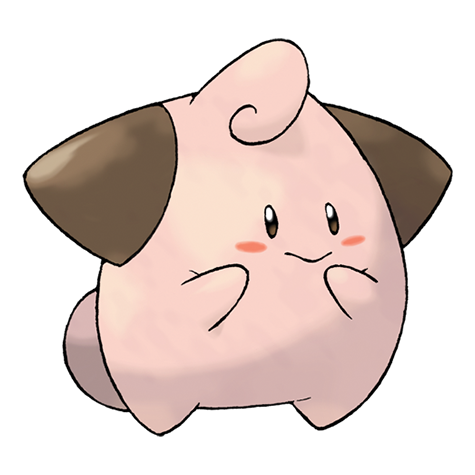

In [ ]:
data[73]["image"]

In [ ]:

data[73]["text"]

'cleffa'

# Embedding Data


In [ ]:
import torch

In [6]:
from transformers import AutoProcessor ,AutoModelForZeroShotImageClassification



/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [7]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
processor=AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
# options:
#clip
#google's

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [9]:
model=AutoModelForZeroShotImageClassification.from_pretrained("openai/clip-vit-large-patch14",device_map=device)


In [ ]:
def embed(batch):
  pixel_values=processor(images=batch["image"],return_tensors="pt")["pixel_values"]
  pixel_values=pixel_values.to(device)
  img_emb=model.get_image_features(pixel_values)
  batch["embeddings"]= img_emb
  return batch
embedded_data=data.map(embed,batched=True,batch_size=16)



# Retrieving images


In [ ]:
from datasets import load_dataset


dataset = load_dataset("not-lain/embedded-pokemon", split="train")

In [2]:
!pip install faiss-cpu



In [ ]:
dataset = dataset.add_faiss_index("embeddings")


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
def search(query,k):

  pixel_values=processor(images=query,return_tensors="pt")['pixel_values']
  pixel_values= pixel_values.to(device)

  img_emb= model.get_image_features(pixel_values)[0]
  img_emb=img_emb.cpu().detach().numpy()

  scores,retrieved_examples=dataset.get_nearest_examples(
      "embeddings",img_emb,
      k=k


  )
  return retrieved_examples

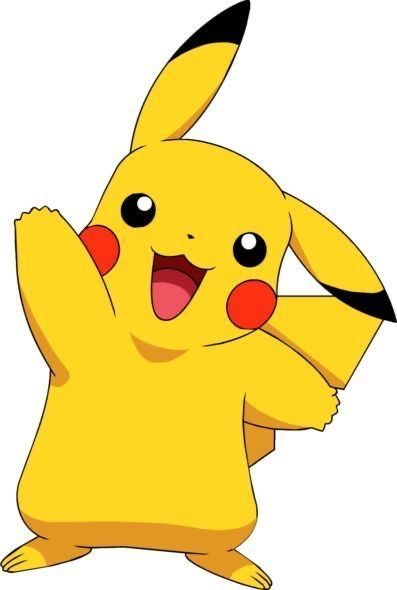

In [ ]:
from PIL import Image
import requests
from io import BytesIO

url = "https://imgs.search.brave.com/D1_liZObR9t_wk-zyR19z6-8ak3vCv9e6Tmlim4_N18/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9pLnBp/bmltZy5jb20vb3Jp/Z2luYWxzLzgxLzM1/L2U2LzgxMzVlNjY1/M2U2NzZjNDhkYTAy/NGViODg5NjM4MWU0/LmpwZw"
image = Image.open(BytesIO(requests.get(url).content)).convert("RGB")

image


In [ ]:
retrieved_examples = search(image, k=6)

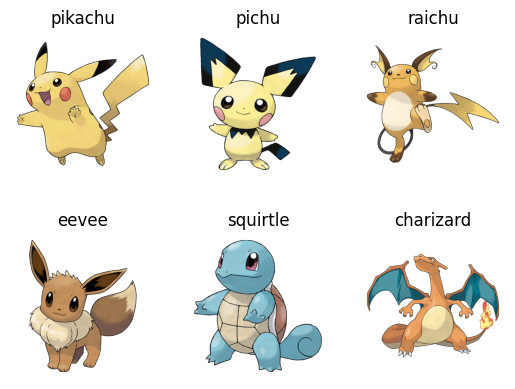

In [ ]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(2,3)
for index in range(6):
    i,j = index//3, index%3
    axarr[i,j].set_title(retrieved_examples["text"][index])
    axarr[i,j].imshow(retrieved_examples["image"][index])
    axarr[i,j].axis('off')
plt.show()


# Now image retrieval on basis of text


In [1]:
from datasets import load_dataset
data=load_dataset("not-lain/pokemon",split="train")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [2]:
import torch

def embed_images(batch):
    with torch.no_grad():
        pixel_values = processor(
            images=batch["image"],
            return_tensors="pt"
        )["pixel_values"].to(device)

        img_emb = model.get_image_features(pixel_values)
        batch["embeddings"] = img_emb.detach().cpu().numpy()

    return batch


In [14]:
import torch

def embed_text(text):
    with torch.no_grad():
        text_inputs = processor(
            text=[text],
            return_tensors="pt",
            padding=True
        ).to(device)

        text_emb = model.get_text_features(**text_inputs)
        return text_emb.detach().cpu().numpy()


In [4]:
# embedding images

In [10]:
data = data.map(
    embed_images,
    batched=True,
    batch_size=16
)


Map:   0%|          | 0/898 [00:00<?, ? examples/s]

In [11]:
# normalizing embeddings 0> normalized vecors
import numpy as np

image_embeddings = np.vstack(data["embeddings"])
image_embeddings = image_embeddings / np.linalg.norm(
    image_embeddings, axis=1, keepdims=True
)


In [15]:
import faiss

dim = image_embeddings.shape[1]
index = faiss.IndexFlatIP(dim)   # IP = inner product

index.add(image_embeddings)


In [31]:
query = "water pokemon"

text_emb = embed_text(query).astype("float32")
text_emb /= np.linalg.norm(text_emb, axis=1, keepdims=True)


In [32]:
k = 6
scores, indices = index.search(text_emb, k)


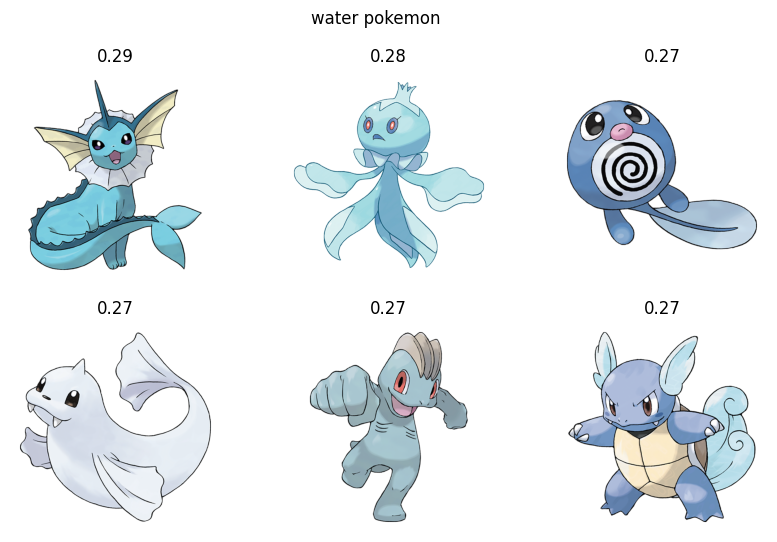

In [33]:
import matplotlib.pyplot as plt

fig, axarr = plt.subplots(2, 3, figsize=(10, 6))

for idx, img_idx in enumerate(indices[0]):
    i, j = idx // 3, idx % 3
    axarr[i, j].imshow(data[int(img_idx)]["image"])
    axarr[i, j].set_title(f"{scores[0][idx]:.2f}")
    axarr[i, j].axis("off")

plt.suptitle(query)
plt.show()
